# Predicting Work Placement Status using Academic Percentages
DSCI 100 Project Proposal \
**Group 005-32**: Imanjosh Chahal, Kahsennaró-roks Deom, Romina Mahinpei

## Introduction

For students, getting a work placement is of great concern. Many students work on obtaining high academic averages so that they can be recognized by employers and ultimately secure a work placement. Seeing this cycle, we chose to take on a classification project and formed the following research question: **can we predict whether an employer will hire students based on their secondary school, high school, undergrad degree, MBA degree, and employability test percentages?**
Our dataset is the [Placement_Data_Full_Class](https://www.kaggle.com/benroshan/factors-affecting-campus-placement), collected by Jain University. The dataset contains 15 variables and 215 observations.

## Preliminary Exploratory Data Analysis
We begin by loading packages, reading the dataset, splitting the data, and summarizing the training data. We also note that our data is already in tidy format, so no wrangling is done. 

In [1]:
# load packages
library(tidyverse)
library(tidymodels)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
set.seed(1) 
# read data from the web
data_url <- "https://raw.githubusercontent.com/DG1606/CMS-R-2020/7f00d6b5e20d99a933c582d8b544fc4d04528462/Placement_Data_Full_Class.csv"
data_original <- read_csv(data_url)
head(data_original)

Parsed with column specification:
cols(
  sl_no = col_double(),
  gender = col_character(),
  ssc_p = col_double(),
  ssc_b = col_character(),
  hsc_p = col_double(),
  hsc_b = col_character(),
  hsc_s = col_character(),
  degree_p = col_double(),
  degree_t = col_character(),
  workex = col_character(),
  etest_p = col_double(),
  specialisation = col_character(),
  mba_p = col_double(),
  status = col_character(),
  salary = col_double()
)



sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NA
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000
6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed,NA


In [3]:
# treat status as a factor
data_original <- mutate(data_original, status = as_factor(status))

# split data into testing set (75% of original data) and training set (25% of original data)
data_split <- initial_split(data_original, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

In [4]:
# summarize training data
summary_table <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    group_by(status) %>%
    summarize(count = n(), 
              mean_ssc_p = mean(ssc_p), 
              mean_hsc_p = mean(hsc_p), 
              mean_degree_p = mean(degree_p), 
              mean_mba_p = mean(mba_p), 
              mean_etest_p = mean(etest_p))
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



status,count,mean_ssc_p,mean_hsc_p,mean_degree_p,mean_mba_p,mean_etest_p
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Placed,111,71.65649,69.95793,68.09279,62.63072,73.54423
Not Placed,51,57.31961,58.24078,61.79431,61.86647,70.38824


We observe that Placed students appear to have higher average academic percentages than Not Placed students. This suggests that students can be classified into two binary groups (Placed vs. Not Placed), thus making this scenario an ideal candidate for classification.

We also display the distributions of our predictors below, which will be further discussed in the next section.  

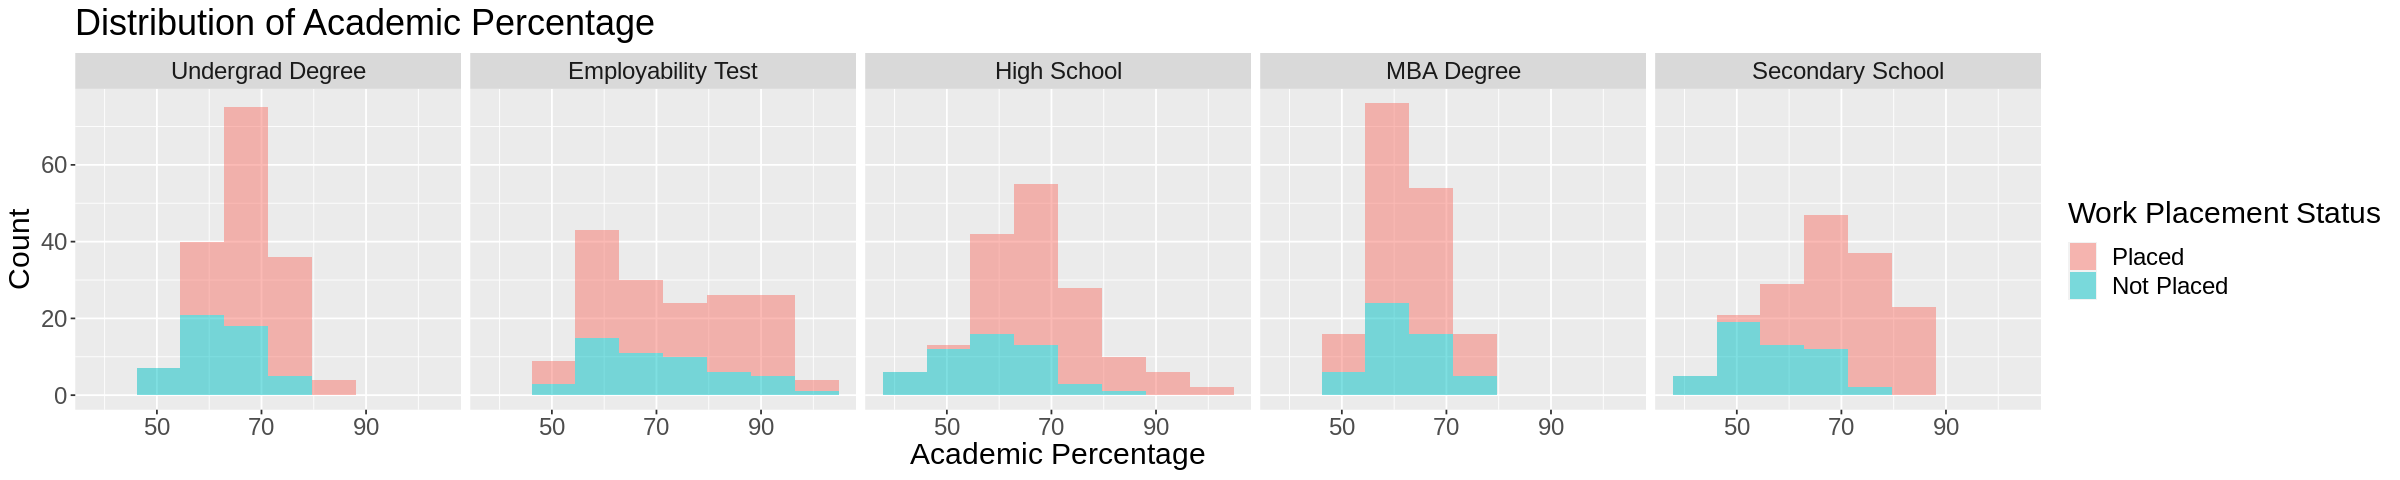

In [8]:
options(repr.plot.width = 20, repr.plot.height = 4)

# adjust data format so that facet_grid can be applied
data_plot <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    pivot_longer(cols = ssc_p:etest_p,
                 names_to = "degree_type",
                 values_to = "gpa_p")

gpa_labels <- c(ssc_p = "Secondary School", 
                hsc_p = "High School", 
                degree_p = "Undergrad Degree",
                mba_p = "MBA Degree", 
                etest_p = "Employability Test")

# create histograms to show distributions of predictors
distribution_predictors <- ggplot(data_plot, aes(x = gpa_p, fill = status)) +
    geom_histogram(bins = 8, alpha = 0.5) + 
    labs(x = "Academic Percentage", y = "Count", fill = "Work Placement Status") +
    facet_grid(. ~ degree_type, labeller = labeller(degree_type = gpa_labels)) + 
    ggtitle("Distribution of Academic Percentage") +
    theme(text = element_text(size = 18))
distribution_predictors

## Methods
We plan to use secondary school, high school, undergrad degree, MBA degree, and employability test percentages to predict whether a student will receive a work placement or not. Thus, we will use ssc_p, hsc_p, degree_p, mba_p, and etest_p variables as our five predictors and treat the status variable as our target variable. To verify that our predictors are relevant, we paired our predictors in all possible combinations (e.g. hsc_p & degree_p, etc.) and created a scatterplot each time. A sample scatterplot from this process is provided below.

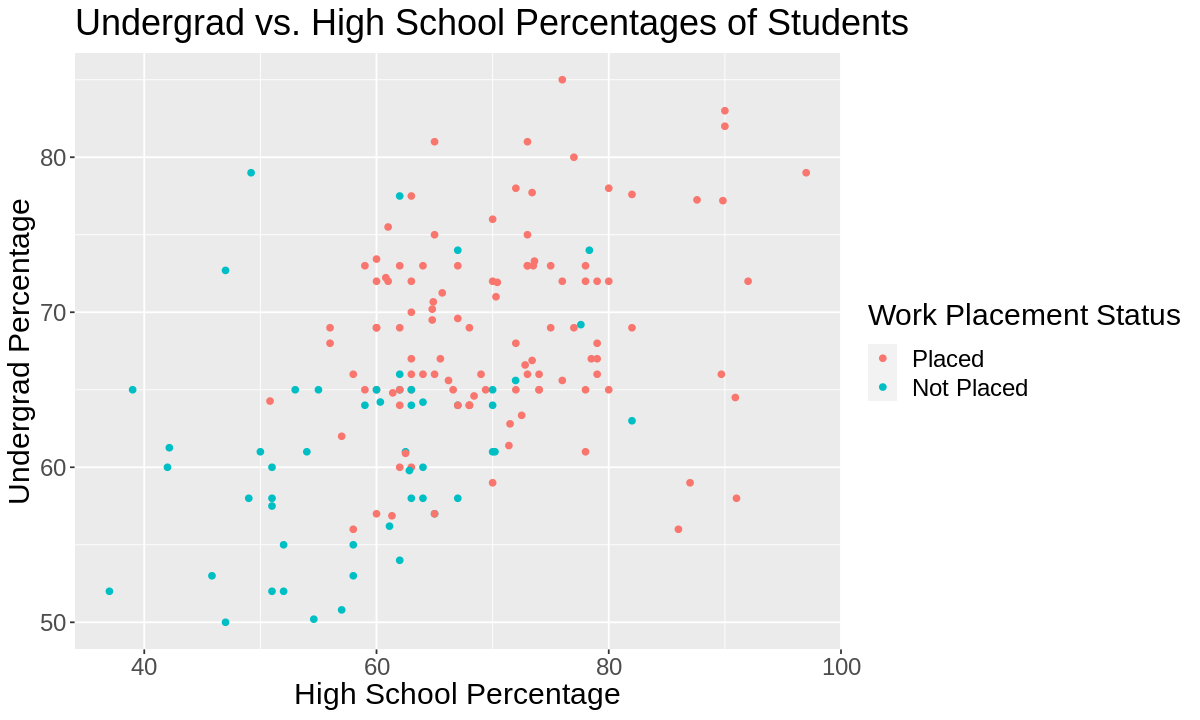

In [25]:
options(repr.plot.width = 10, repr.plot.height = 6)

# create a sample scatterplot 
scatterplot <- ggplot(data_train, aes(x = hsc_p, y = degree_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("High School Percentage") +
    ylab("Undergrad Percentage") +
    ggtitle("Undergrad vs. High School Percentages of Students") +
    theme(text = element_text(size = 18))
scatterplot

In all scatterplots, we observed distinct clusters for the two levels of our target variable. This assures us that our chosen predictors are relevant.

As for training our classification model, we will use the K-nearest neighbours algorithm. We will visualize our data using scatterplots. We will pair our predictors (e.g. hsc_p & degree_p, etc.) and treat one predictor as the variable on the x-axis and the other predictor as the variable on the y-axis and also colour our points based on their labels.

## Expected Outcomes & Significance
From our preliminary exploration, we observed that students appeared in distinct clusters. The cluster of Placed students often had higher academic averages than the cluster of Not Placed students. These observations lead us to believe that work placement can be predicted using academic percentages. These findings are impactful since they will inform students on whether they should maintain or change their study habits in order to improve their academic percentages for a work placement.

## Future Questions
After concluding this project, it will be interesting to investigate whether our results apply to other countries. We acknowledge that our dataset only contains information on Indian students, so our results may not apply to students from other regions. By conducting this investigation with datasets from different countries, we will see whether work placement status can/cannot be predicted from academic percentages in other regions.